# Урок 7. Интерпретация прогнозов модели (SHAP) - объясняем поведение модели на отдельных наблюдениях

Программа урока:

1. Теоретическая часть:
    - Проблема интерпретируемости моделей
    - Примеры, когда это важно
    - Обзор методов

2. Практическая часть:
    - Feature importance, доступный в самих моделях
    - Permutation Importance
    - SHAP

**Инструменты интерпретация результатов работы модели:**

* Yellowbrick
* ell5
* MLxtend
* LIME
* SHAP

На уроке будет затронут важный для любого бизнеса, применяющего машинное обучение при решении задач, аспект - интерпретируемость моделей. Т.е важно не только умение обучать модели, которые делают качественные прогнозы, но и умение объяснить эти прогнозы. Когда мы не просто понимаем, что пользователь склонен совершить некоторое действие (например, уйти в отток), но и можем выявить факторы, влияющие на это, что позволяет скорректировать стратегию взаимодействия с пользователями (как пример). Такая модель может быть полезна не только своими прогнозами, но и инсайтами, которые скрыты в данных. 

## Проблема интерпретируемости моделей машинного обучения

Интерпретируемость – это возможность объяснить прогнозы модели на понятном бизнесу языке

Черный ящик (так часто видят ML)

![ab_split](images/blackbox.png "blackbox ML")

Особенности:

1. мы получаем прогнозы, которые приносят пользу (ну, должны)
2. мы не можем внятно объяснить почему прогнозы именно такие и что именно повлияло на принятие решения модели

![ab_split](images/blackbox2.png "blackbox ML + inter")

Интерпретация прогнозов модели может дать интересные инсайты о том, какая у нас аудитория (вспоминаем uplift-моделирование)

Иногда же на практике интерпретируемость является критичным моментом

Как выглядит процесс: 

1. есть реальный мир
2. мы векторизуем его (как можем - получаем признаки)
3. строим модель
4. интерпретируем
5. объясняем людям поведение модели


![ab_split](images/inter2.png "inter1")

![ab_split](images/inter1.png "inter1")

* картинка взята с https://habr.com/ru/company/otus/blog/464695/

## Обзор методов

- важные признаки в модели (feature importance)
- влияние каждого отдельного признака на конкретный прогноз 
- влияние каждого признака на большое количество возможных прогнозов (топ k наблюдений, например)

## 1. Feature importance признаков

### Пример с линейной моделью

Набор данных взят отсюда - https://www.kaggle.com/harlfoxem/housesalesprediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
df = pd.read_csv("kc_house_data.csv")
print(df.shape)
df.head(3)

(21613, 21)


id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   

   sqft_lot15  
0        5650  
1        7639  
2        8062  

[3 rows x 21 columns]

В качестве предикторов (признаков) будем использовать 4 - bedrooms, sqft_living, sqft_lot и yr_built

Целевая переменная - price (цена)

In [2]:
features = ["bedrooms", "sqft_living", "sqft_lot", "yr_built"]
target = "price"

#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], random_state=0)

In [4]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Соберем пайплайн

In [5]:
continuous_columns = ["bedrooms", "yr_built", 'sqft_living', 'sqft_lot']
final_transformers = list()
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))
    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Модель - линейная регрессия

In [6]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

In [7]:
#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bedrooms',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('yr_built',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='yr_built')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('sqft_living',
                                                 Pipeline(steps=[('selector',
                         

Посчитаем MAE и коэффициент детерминации (R2)

In [8]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(162462.4957386193, 0.5365765901167386)

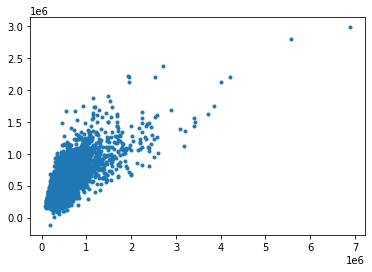

In [9]:
import matplotlib.pyplot as plt

plt.plot(y_test, predictions, '.')
plt.show()

mae малоинформативен, но вот r2 - очень понятен.

На случай, если кто забыл:

![r2](images/r2.png "R2 score")

Интерпретация:

1. принимает значения от -1 до 1. Чем ближе к 1, тем лучше модель объясняет данные (соответствует модели данных)
2. значение 1 означает функциональную зависимость y от X
3. В общем случае коэффициент детерминации может быть и отрицательным, это говорит о крайней неадекватности модели: простое среднее приближает лучше

источник на вики - https://ru.wikipedia.org/wiki/Коэффициент_детерминации

Наконец, давайте посмотрим на "важность" признаков (в линейной регрессии это просто веса (коэффициенты) при предикторах (признаках)

Сразу же возьмем абсолютные значения коэффициентов

In [10]:
intercept = regressor[1].intercept_
features = pd.DataFrame(regressor[1].coef_, 
                        continuous_columns, 
                        columns=['coefficient'])
features.head()

coefficient
bedrooms     -55705.016661
yr_built     -71039.334129
sqft_living  316113.766523
sqft_lot     -14820.959494

Как это можно интерпретировать:

1. sqft_living имеет наибольшую важность и положителен (чем выше жилая площадь, тем выше стоимость)
2. остальные признаки уже идут с отрицательным весом
3. вторым по важности признаком является год постройки (yr_built)

### Перейдем к "деревянным" моделям

In [8]:
import xgboost as xgb

/Users/artemzraev/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
regressor = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBRegressor()),
])

#обучим наш пайплайн
regressor.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('bedrooms',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='bedrooms')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('yr_built',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='yr_built')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('sqft_living',
                                                 Pipeline(steps=[('selector',
                         

In [10]:
predictions =  regressor.predict(X_test)
 
mean_absolute_error(y_pred=predictions, y_true=y_test), r2_score(y_pred=predictions, y_true=y_test)

(147549.13301778774, 0.5857872812293717)

In [11]:
xgb_features = pd.DataFrame(regressor[1].feature_importances_, 
                        continuous_columns, 
                        columns=['coefficient'])
xgb_features.head()

coefficient
bedrooms        0.064880
yr_built        0.122114
sqft_living     0.714649
sqft_lot        0.098357

Жилая площадь - самый важный признак, описывает >70% предсказания.

Как можно считать feature_importance в моделях на базе деревьев решений

![xgboost](images/xgboost_tree.png "Xgboost tree")

Ссылка (рекомендую поизучать на досуге) - https://xgboost.readthedocs.io/en/latest/tutorials/model.html

Существует несколько вариантов как для признака в деревьях решений посчитать важность

1. Gain - показывает относительный вклад каждой фичи в модель. 
Алгоритм простой - идем по каждому дереву, смотрим в каждом узле дерева по какому признаку происходит разбиение узла и насколько снижаетcя неопределенность (gini impurity, information gain). Далее для каждого признака суммируется её вклад (по всем деревьям)

2. Frequency - показывает, как часто конкретный признак встречается в узлах дерева, то есть считается суммарное количество разбиений дерева на узлы для каждого признака в каждом дереве.

<b>Вопрос:</b>
Какие еще вы знаете модели со "встроенной" возможностью определять важность признаков?

Ваш ответ: GD, RandomForest, DecisionTree

#### Краткий вывод:

Подходы, основанные на feature_importance, очень удобны, т.к по факту мы получаем готовый функционал и можем хоть какую-то интерпретацию давать без каких-либо внешних инструментов.

Однако проблема такого подхода заключается в том, что непонятно, как именно данная фича влияет на итоговый прогноз. 

Пример: жилая площадь важна для прогноза стоимости жилья, но как именно это может быть связано с другими признаками? Это будет в пункте 3, а сейчас давайте рассмотрим еще один (из множества) способ расчета "важности" признаков

## 2. Permutation importance

Алгоритм очень простой:

- обучаем модель на тренировочном наборе данных
- проверяем качество на валидации
- для валидационного набора данных перемешиваем один из признаков
- снова проверяем качество на нем же

Признак считается «важным», если качество модели падает при его перемешивании.

Очень удобно, что в sklearn есть возможность из коробки такое делать

In [12]:
from sklearn.inspection import permutation_importance
r = permutation_importance(regressor, X_test, y_test,
                            n_repeats=30, # сколько раз перемешиваем каждый признак!
                            random_state=0)

Пример как это может выглядеть на выходе

In [13]:
for i in r.importances_mean.argsort()[::-1]:
    print(f"{continuous_columns[i]:<8} "
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

yr_built 1.560 +/- 0.043
sqft_lot 0.145 +/- 0.015
sqft_living 0.104 +/- 0.011
bedrooms 0.065 +/- 0.007


Получили среднее значение важности для каждого признака. Чем выше среднее значение важности, тем выше важность признака. Как влияет признак на таргет - непонятно!

Интересно, что результаты немного другие, нежели при использовании "встроенного" feature_importances_)

https://www.kaggle.com/ogrellier/feature-selection-with-null-importances

## 3. SHAP

Специальный инструмент для интерпретации модели

* ссылка на проект - https://github.com/slundberg/shap

* Wiki - https://en.wikipedia.org/wiki/Shapley_value

Значения Шэпли пришли к нам из теории игр.

Пример - группа людей (далее - коалиция) играет в игру. 

Необходимо распределить призовой фонд между ними в зависимости от их вклада.

Уточнения (допущения):

- игроки с равным вкладом должны получить одинаковую награду
- если вклад игрока нулевой, то награда также нулевая
- если игрок провел несколько игр, то его награда - это сумма наград за каждую из игр

Немного математики (ссылка - https://en.wikipedia.org/wiki/Shapley_value)

![shap2](images/shap2.png "SHAP 1")

u - это выигрыш команды

n - количество игроков

S - коалиция (подмножество из n без игрока i)

А теперь попробуем "переложить" все это на вариант с задачей обучения с учителем

- игра - результат обучения с учителем (на основе заданного примера)
#- выигрыш – это разница между матожиданием результата на всех имеющихся примерах и результатом, полученном на заданном примере
- вклады игроков в игру – влияние каждого значения признака на выигрыш, т.е. результат.

Значение Шэпли для i-той фичи рассчитывается для каждого сэмпла данных (каждого наблюдения) на всех возможных комбинациях фичей (включая отсутствие всех фичей), затем полученные значения суммируются по модулю и получается итоговая важность i-той фичи.

Расчет SHAP values очень тяжелый и затратный как по времени так и по ресурсам!

![ab_split](images/shap1.png "SHAP 1")

SHAP расшифровывается как SHapley Additive explanation. Этот метод помогает разбить на части прогноз, чтобы выявить значение каждого признака. 

Он основан на Векторе Шепли - принципе, используемом в теории игр для определения, насколько каждый игрок при совместной игре способствует ее успешному исходу (https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80). 

### Игрушечный пример 

#### Пример №1

ссылка - https://arxiv.org/pdf/1802.03888.pdf

![shap4](images/shap4.png "SHAP 4")

На выходе для комбинации {Fever=Yes, Cough=Yes} хотим получить значимость признаков (т.е для конкретного наблюдения). 

Посчитаем выход модели для каждой возможной комбинации признаков:

![shap4](images/shap3.png "SHAP 3")

Теперь посчитаем SHAP для признака Fever для модели А (левое дерево).

Для этого посчитаем все необходимое для комбинаций признаков, которые не включают Fever:
![shap4](images/shap5.png "SHAP 5")

таких у нас 2:
![shap4](images/shap6.png "SHAP 6")

Подставляем значения в формулу и получаем SHAP для признака Fever:

![shap7](images/shap7.png "SHAP 7")

А теперь для признака Cough:

![shap8](images/shap8.png "SHAP 8")

Для модели B (дерево справа) получаем такое:

![shap9](images/shap9.png "SHAP 9")

Получаем значимость признаков на уровне одного примера с конкретными значениями признаков. 

* phi_0 - ожидаемый результат (для первой модели мы можем попасть в один из 4 листьев - ответ 20, для второй - 25)
* phi - ответ модели для конкретного наблюдения ({Fever=True, Cough=True}) - для первой модели 80, для второй - 90

#### Пример №2

![example_xgboost](images/example_xgboost_tree.PNG "Example Xgboost tree")

+2/+0.1/-1 - это все предсказания!!!!

![shap2](images/shap2.png "SHAP 1")

u - это выигрыш команды - это разница между матожиданием результата на всех имеющихся примерах и результатом, полученном на заданном примере

n - количество игроков - количество признаков

S - коалиция (подмножество из n без игрока i)

Мы хотим оценить важность фичей для предсказания, нравятся ли человеку компьютерные игры.

В этом примере у нас есть две фичи: age (возраст) и gender (пол). Gender (пол) принимает значение 0 или 1.

Возьмем мальчика и посчитаем значение Шэпли для фичи age (возраст).

У нас есть два набора фичей S:

$\big\{\big\}$ - нет фичей

$\big\{ gender \big\}$ - есть только фича пол.

**Ситуация, когда нет значений фичей**

Когда для объекта нет фичей, то есть для всех фичей значения равны NULL.

Будем считать в данном случае, что модель усредняет предсказания по веткам дерева, то предсказание без фичей будет $\frac{\frac{2+0.1}{2} + (-1)}{2} = 0.025$.

Если же мы добавим знание возраста, то предсказание модели будет $\frac{2+0.1}{2} = 1.05$.

В итоге значение Шэпли для случая отсутствия фичей:

$$\frac{|S|! (n-|S|-1)!}{n!}\Big(p\big(S \cup \{i\}\big) - p\big(S\big)\Big) = \frac{1!(2-1-1)!}{2!}(1.05 - 0.025) = 0.5125$$

**Ситуация, когда знаем пол**

Для мальчика для $gender$ предсказание без фичи возраст, только с фичей пол, равно $\frac{2 + (-1)}{2}=0.5$. Если же мы знаем возраст, то предсказание - это самое левое дерево, то есть 2.

В итоге значение Шэпли для этого случая:

$$\frac{|S|! (n-|S|-1)!}{n!}\Big(p\big(S \cup \{i\}\big) - p\big(S\big)\Big) = \frac{1!(2-1-1)!}{2!}(2-0.5) = 0.75$$

**Суммируем**

Итоговое значение Шэпли для фичи age (возраст): 

$$\phi_{Age\;Мальчик} = 0.75 + 0.5125 = 1.2625$$

### Пример (данные оттока с 5 занятия)

In [1]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('churn_data.csv')
features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df[features], df['Exited'], random_state=0)

LGBM

Отрисовка идет по двум классам

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


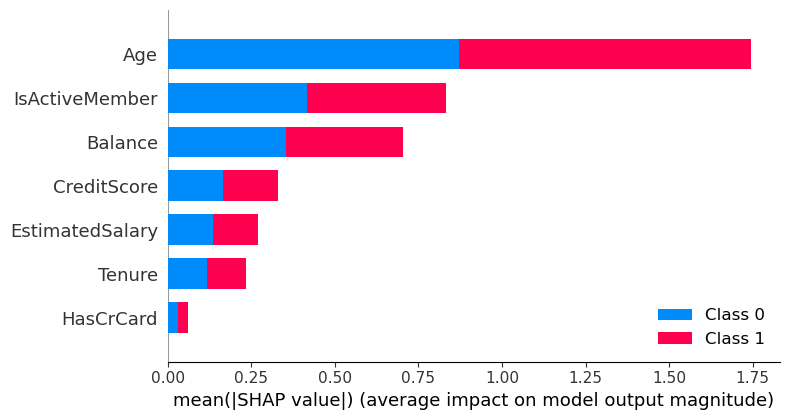

In [6]:
from lightgbm import LGBMClassifier

lgb_model = LGBMClassifier(random_state=1)
lgb_model.fit(X_train, y_train)

y_preds = lgb_model.predict(X_test)

# строим модель обьяснения SHAP
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# покажем обьяснение
shap.initjs()
shap.summary_plot(shap_values, X_test)

Поэтому будем анализировать только первый класс - целевой. В модели LightGBM в shap_values возвращаются все значения: и класс 1, и класс 0. Нам нужен только целевой класс.

Explained expected value: [[ 0.26523924 -0.28784411 -0.02476329 ...  0.00193978 -0.23554534
   0.77842429]
 [ 0.15279986  0.08858975  0.01532082 ...  0.024941    0.38710433
   0.08548294]
 [-0.08995534  0.77079893 -0.14926007 ... -0.02106527 -0.37591704
  -0.13108439]
 ...
 [-0.23736179  0.22291486  0.23952641 ...  0.02894487  0.33199655
  -0.057909  ]
 [ 0.0053646  -0.09800867 -0.19296061 ...  0.00856817  0.34411054
  -0.00239543]
 [ 0.08495217 -0.84792256  0.12704768 ...  0.09238912  0.47486202
   0.04266354]]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


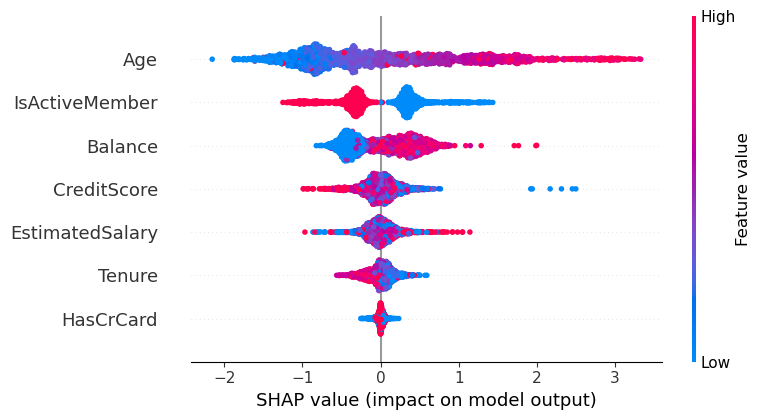

In [7]:
if isinstance(shap_values, list):
    shap_values = shap_values[1]

print(f"Explained expected value: {shap_values}")

shap.summary_plot(shap_values, X_test)

Например, в XGBoost нету такой херни. В нем по умолчанию SHAP возвращает **целевой класс**

С каждым объектом и признаком связывается величина выигрыша или проигрыша. Она показывает, что данное значение поднимало ответ нашей модели или опускало:
* положительные значения - увеличиваелся ответ (справа от вертикальной линии, целевой класс)
* отрицательные значения - уменьшался ответ (слева от вертикальной линии, нецелевой класс)

А результирующий график - это
* толщина полосы - как много таких значений
* длина полосы - какой вклад вносится в ответ
* high/low - значения в самом признаке

**Пара интепретаций:**

1. Пожилые люди (High Age) как и положительный вклад дают в отток, так и отрицательный.
2. Маленькое отрицательное влияние оказывают молодые люди
3. А люди среднего возраста оказывают нейтральное влияние на отток.
4. Высокий баланс стремится к оттоку, а низкий баланс нет.

In [8]:
X_train.shape

(7500, 7)

XGB

Отрисовка по целевому классу

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


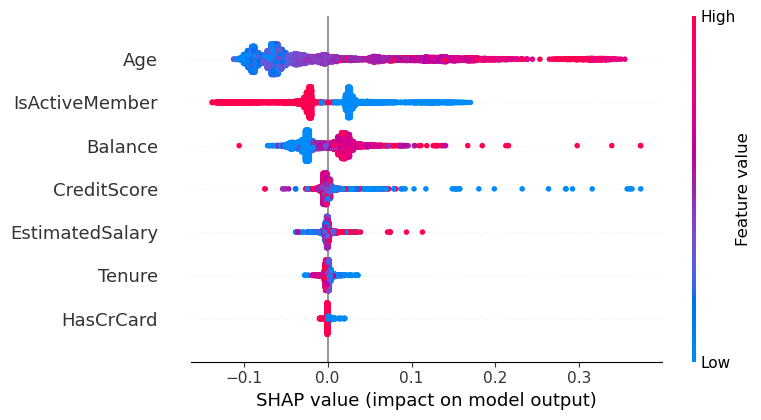

In [9]:
model = xgboost.train({'learning_rate':0.01, 'random_state':1},
                     xgboost.DMatrix(X_train, label=y_train), 100)

explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_train)

shap.summary_plot(shap_values_all, X_train)

Здесь видим, уже другие значения по сравнению с LightGBM

**Пара интерпретаций:**

1. Положительные люди в этой модели дают только положительный вклад в отток, за исключением пары объектов на левой части.
2. Маленькое отрицательное влияние оказывают молодые люди.

Интерпретация конкретного объекта:

In [10]:
shap.initjs()
idx = 1
shap.force_plot(explainer.expected_value, shap_values_all[idx, :], X_train.iloc[idx,:])

Выше видим, что у человека вероятность оттока (0.23) и видим вклад признаков в этот результат:

* Человек неактивный пользователь и это тянет его вероятность вверх
* А вот то, что человек молодой и у него баланс нулевой - это тянет вероятность вниз.

In [11]:
shap.initjs()
idx = 10
shap.force_plot(explainer.expected_value, shap_values_all[idx, :], X_train.iloc[idx,:])

In [12]:
shap.initjs()
idx = 100
shap.force_plot(explainer.expected_value, shap_values_all[idx, :], X_train.iloc[idx,:])

Теперь можем работать с конкретными клиентами и давить на нужные места.

А еще можем отрисовать верхние диаграммы немного иначе, через waterfall:

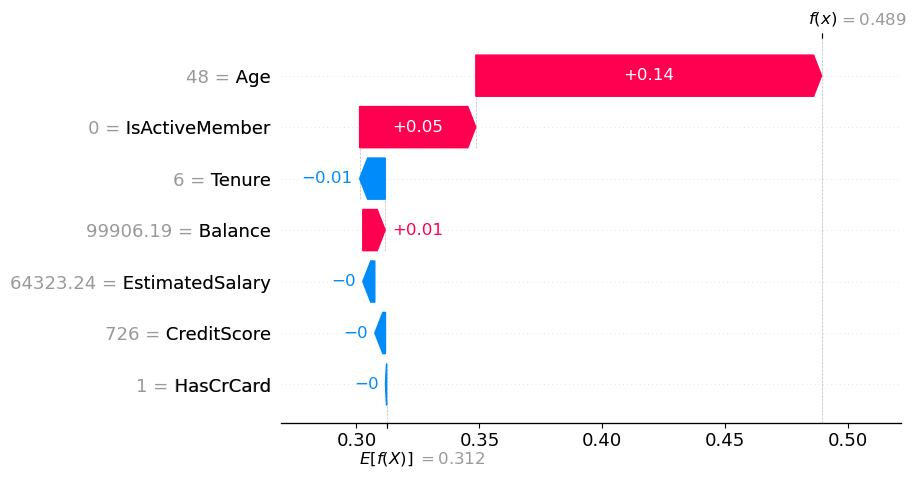

In [13]:
shap_values_one = explainer(X_train.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

Можно даже просто взять средниен значения SHAP для каждого признака

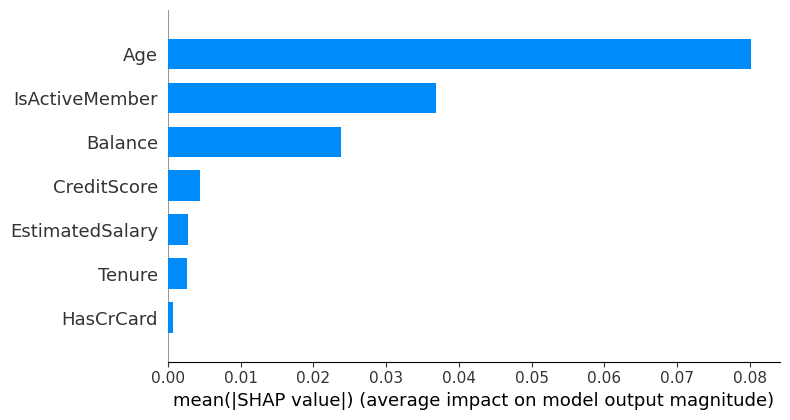

In [14]:
shap.summary_plot(shap_values_all, X_train, plot_type='bar')

Есть визуализации через тепловые карты. Это для визуализации вклада по всем данным.

Такие диаграммы еще могут и определить признаки, которые решают задачу. К примеру, видим, что 

1. По факту три признака описывают нашу задачу
2. Большое значение нашего таргета описываются возрастом с большим shap значением

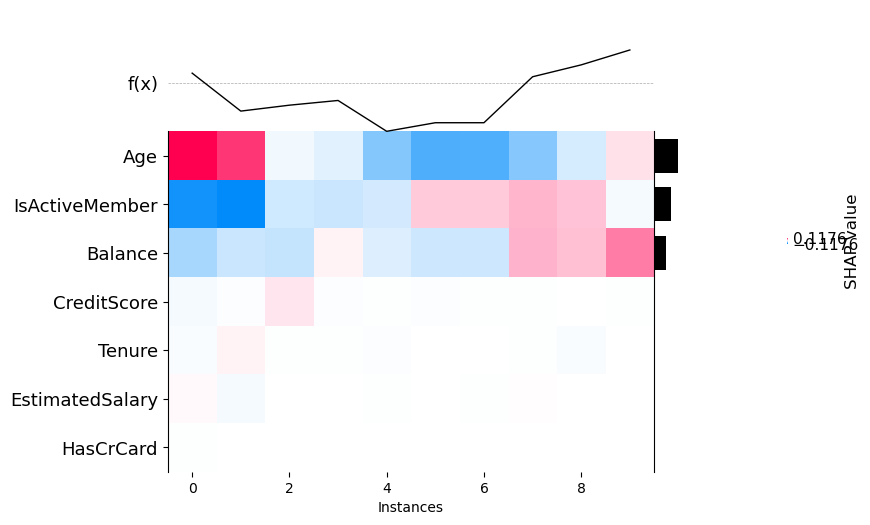

In [15]:
n = 10
shap_values = explainer(X_train.iloc[:n])
shap.plots.heatmap(shap_values)

Следующая диаграмма позволяет в интерактивном режиме посмотреть на все решения, которые были сделаны. Можно смотреть в нескольких разрезах.

In [16]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_all[:n], X_train.iloc[:n])

## Eli5

!pip install eli5

Во-первых, библиотека позволяет анализировать веса модели для оценивания поведения модели.

In [18]:
import eli5

eli5.show_weights(model, feature_names=X_train.columns.tolist())

numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


Во-вторых, она позволяет анализировать вклад признаков и их значений в конкретные объекты

In [19]:
from eli5 import show_prediction

In [21]:
idx = 10
show_prediction(model, X_train.iloc[idx], feature_names=X_train.columns.tolist(), show_feature_values=True)

explain_weights_sklearn() - метод, позволяющий вернуть explainer объект. Мы можем теперь накладывать на него разные форматирования.

In [22]:
from sklearn.tree import DecisionTreeClassifier

n=100
tree_model = DecisionTreeClassifier(random_state=1)
tree_model.fit(X_train.iloc[:n], y_train[:n])

DecisionTreeClassifier(random_state=1)

In [23]:
from eli5.sklearn import explain_weights_sklearn

explatation = explain_weights_sklearn(tree_model, feature_names=X_train.columns.tolist())
type(explatation)

eli5.base.Explanation

In [24]:
from eli5.formatters import format_as_dataframe

format_as_dataframe(explatation)

feature    weight
0      CreditScore  0.269892
1              Age  0.248007
2  EstimatedSalary  0.215968
3          Balance  0.107240
4   IsActiveMember  0.093537
5           Tenure  0.065355
6        HasCrCard  0.000000

In [25]:
from eli5.formatters import format_as_text

print(format_as_text(explatation))

Explained as: decision tree

Decision tree feature importances; values are numbers 0 <= x <= 1;
all values sum to 1.

0.2699  CreditScore
0.2480  Age
0.2160  EstimatedSalary
0.1072  Balance
0.0935  IsActiveMember
0.0654  Tenure
     0  HasCrCard

Age <= 37.500  (47.0%)
    Tenure <= 1.500  (4.0%)
        EstimatedSalary <= 131720.016  (3.0%)  ---> 0.000
        EstimatedSalary > 131720.016  (1.0%)  ---> 1.000
    Tenure > 1.500  (43.0%)
        CreditScore <= 722.000  (31.0%)  ---> 0.000
        CreditScore > 722.000  (12.0%)
            CreditScore <= 726.500  (1.0%)  ---> 1.000
            CreditScore > 726.500  (11.0%)  ---> 0.000
Age > 37.500  (53.0%)
    Balance <= 115596.574  (33.0%)
        CreditScore <= 775.500  (31.0%)
            CreditScore <= 532.000  (4.0%)
                EstimatedSalary <= 155196.945  (3.0%)  ---> 1.000
                EstimatedSalary > 155196.945  (1.0%)  ---> 0.000
            CreditScore > 532.000  (27.0%)
                EstimatedSalary <= 9602.615 

Можно и html файлом

In [26]:
from eli5.formatters import format_as_html
from IPython.display import HTML

html_rep = format_as_html(explatation)
HTML(data=html_rep)

## LIME

!pip install lime

In [28]:
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                   class_names=y_train.unique())

Также используем интерпретатор для расшифровки прогноза. Результат приведен ниже. При помощи Lime можно создать визуализацию, отображающую влияние конкретных признаков на прогноз.

In [29]:
idx = 0
# обьясняем по 1 объекту (instance)
exp = explainer.explain_instance(X_train.iloc[idx].values, tree_model.predict_proba, num_features=6)
exp.show_in_notebook(show_all=False)

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


## Домашнее задание

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

## Ссылки:
- Пример с Permutation Importance - https://www.kaggle.com/dansbecker/permutation-importance
- Github проекта SHAP - https://github.com/slundberg/shap
- https://arxiv.org/pdf/1809.04559.pdf
- https://medium.com/civis-analytics/demystifying-black-box-models-with-shap-value-analysis-3e20b536fc80
- https://en.wikipedia.org/wiki/Shapley_value

Feature selection:

1. RFE - recursive feature elimination (есть в sklearn)
2. Boruta - shadow features
3. Target permutation 

---